In [0]:
# Makes plots / images embedded in the file
%matplotlib inline

In [0]:
from zipfile import ZipFile
from urllib.request import urlopen
import numpy as np

URL = 'https://uwmadison-cs534-term-project-f2018-cdh.github.io/assets/datasets/environment.zip'

url = urlopen(URL)
output = open('environment.zip','wb')
output.write(url.read())
output.close()

zip_ref = ZipFile('environment.zip', 'r')
zip_ref.extractall('./dataset')
zip_ref.close()

In [0]:
# Import data and keras layers

from keras import backend as k
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Dense, Reshape, Conv2DTranspose
from keras.layers import Flatten, Dropout, BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
import os

files = os.listdir('./dataset/environment')
for name in files:
    print(name)

environment_label.npy
environment_image.npy


In [0]:
x1_raw = np.load('./dataset/environment/environment_image.npy')
y1_raw = np.load('./dataset/environment/environment_label.npy')

x1_test = np.array([])
y1_test = np.array([])

#Optimizer
adam = Adam(lr=2e-4, beta_1=0.5)

In [0]:
filterLbls = ['items_weapon','items_weapons','items_weapon_ranged','items_weapon_artefact']
#'items_wand','items_staff','items_rod'

y1_train = []

firstTime = True
for i in range(y1_raw.shape[0]):
  
  if y1_raw[i] in filterLbls:
    y1_train.append(y1_raw[i])
    
    if firstTime:
      firstTime = False
      raw = x1_raw[i,:,:,:]
      x1_train = np.reshape(raw,(1,raw.shape[0],raw.shape[1],raw.shape[2]))
    else:
      raw = x1_raw[i,:,:,:]
      raw = np.reshape(raw,(1,raw.shape[0],raw.shape[1],raw.shape[2]))
      x1_train = np.concatenate((x1_train,raw), axis=0)
    
y1_train = np.array(y1_train)


In [0]:
x1_train = x1_raw
y1_train = y1_raw

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  featurewise_center = True,
  featurewise_std_normalization = True,
  rotation_range = 60,
  width_shift_range = 0.2,
  height_shift_range = 0.2,
  shear_range = 0.2,
  zoom_range = 0.2
)

datagen.fit(x1_train)

In [0]:
# Creating the generator
generator = Sequential()
generator.add(Dense(512*4*4, activation='relu', input_dim = 100))
generator.add(BatchNormalization())
generator.add(Reshape((4, 4, 512)))
generator.add(Conv2DTranspose(256, (5,5), strides=(2,2), padding='same', activation='relu'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, (5, 5), strides=(2,2), padding='same', activation='relu'))
generator.add(Conv2DTranspose(4, (5, 5), strides=(2,2), padding='same', activation='tanh'))

print(generator.summary())
generator.compile(loss = 'binary_crossentropy', optimizer = adam)  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       819328    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 4)         12804     
Total para

In [0]:
# Creating the discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size = (5, 5), strides = (2, 2), padding = 'same', input_shape = (32, 32, 4)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(64, kernel_size = (5, 5), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Conv2D(128, kernel_size = (5, 5), strides = (2, 2), padding = 'same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation = 'sigmoid'))

print(discriminator.summary())
discriminator.compile(loss = 'binary_crossentropy', optimizer = adam) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 32)        3232      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
__________

In [0]:
# Create the GAN
discriminator.trainable = False
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss = 'binary_crossentropy', optimizer = adam)

In [0]:
# Visualize generated data
def plotGeneratedImages():
  generated_images = generator.predict(noise)
  fig = plt.figure(figsize=(9, 9))        
  for i in range(9 if generated_images.shape[0] > 9 else generated_images.shape[0]):
    plt.subplot(3, 3, i+1)
    img = np.clip(generated_images[i, :],0,1)
    img = img.reshape((32, 32, 4))
    plt.tight_layout()
    plt.imshow(img)
    plt.axis('off')

epoch: 999: 100%|██████████| 71/71 [00:06<00:00, 11.53it/s]


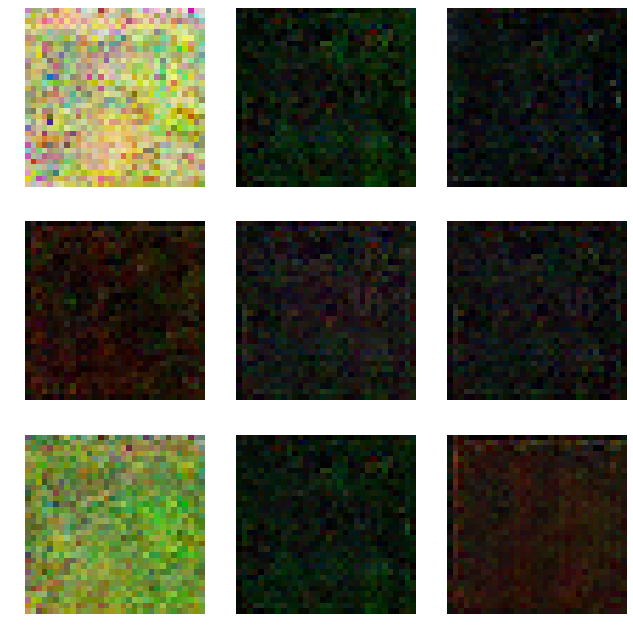

In [0]:
epochs = 1000
batch_size = 32

batch_count = int(x1_train.shape[0] / batch_size)

iterator = datagen.flow(x1_train, batch_size=batch_size)

for epoch in range(epochs):
  
    description = 'epoch: ' + str(epoch)

    for index in tqdm(range(batch_count),desc=description):
        
        # Real images
        image_batch = x1_train[index * batch_size: (index + 1) * batch_size]
        #image_batch = iterator.next()
        
        # Get initial random input for generator
        noise = np.random.uniform(-1, 1, size=[batch_size, 100])
        
        # Generating images
        generated_data = generator.predict_on_batch(noise)

        # Train discriminator
        
        discriminator.trainable = True
        
        X = image_batch
        y = np.zeros(image_batch.shape[0])
        
        discriminator.train_on_batch(x=X, y=y)
        
        #X = np.concatenate((image_batch,generated_data))
        #y = np.concatenate((np.zeros(image_batch.shape[0]),np.ones(batch_size)))
        
        X = generated_data
        y = np.ones(batch_size)
      
        discriminator.train_on_batch(x=X, y=y)
        
        # Train generator 
        y = np.zeros(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(x=noise, y=y)
        
        img = generated_images = generator.predict(noise)   
        
    
plotGeneratedImages()


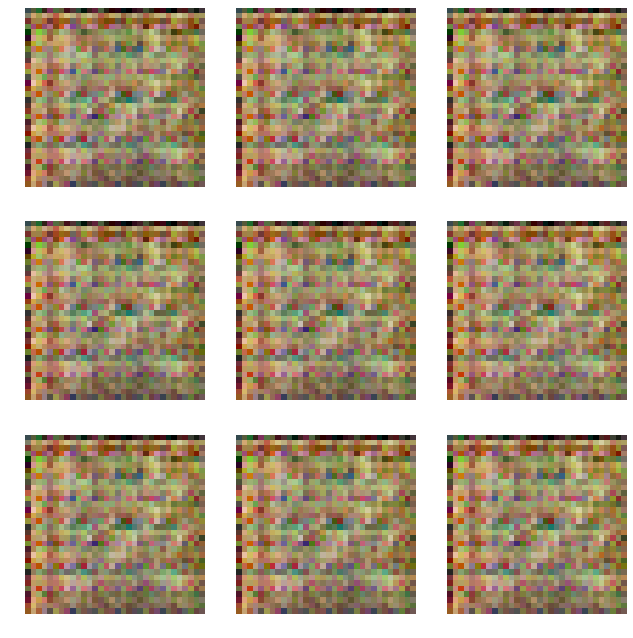

In [0]:
noise = np.random.uniform(-1, 1, size=[9, 100])
plotGeneratedImages()

In [0]:
from google.colab import files
import matplotlib.image as mpimg
import uuid

images = 20
noise = np.random.uniform(-1, 1, size=[images, 100])
generated_images = generator.predict(noise)    
for i in range(images):
  name = str(uuid.uuid4().hex) + '.png'
  img = np.reshape(np.clip(generated_images[i, :],0,1),(32, 32, 4))
  mpimg.imsave(name, img)             
  files.download(name)


In [0]:
from keras.models import load_model
from google.colab import files

model_name = 'dcgan-sprite-item-weapon-3000-epoch.h5'
gan.save(model_name)
files.download(model_name)
